In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import pywt
from scipy.signal import spectrogram
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings("ignore")

# ======= Блок 1: Загрузка данных =======

In [4]:
df = pd.read_csv('final_dataset.csv')  # Укажите правильный путь к файлу

# ======= Блок 2: Анализ данных (EDA) =======

In [6]:
df.head(6)

,Clean_Signal,Noisy_Signal,Class
0,-0.050548,0.120108,0
1,-0.022422,-0.007673,0
2,0.430269,1.163845,1
3,0.101930,0.100857,0
4,1.462921,2.911377,1
5,0.045052,0.629904,1


In [7]:
print("Описание данных:")
print(df.describe())
print("\nИнформация о данных:")
print(df.info())

Описание данных:
       Clean_Signal  Noisy_Signal        Class
count   1140.000000   1140.000000  1140.000000
mean       0.385358      0.407613     0.500000
std        0.799218      1.415405     0.500219
min       -0.439516     -5.548454     0.000000
25%       -0.036589     -0.136737     0.000000
50%        0.047115      0.026706     0.500000
75%        0.273652      0.792827     1.000000
max        2.597387      5.935543     1.000000

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Clean_Signal  1140 non-null   float64
 1   Noisy_Signal  1140 non-null   float64
 2   Class         1140 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 26.8 KB
None


# Проверка на пропущенные значения

In [9]:
print("\nКоличество пропущенных значений в каждом столбце:")
print(df.isnull().sum())


Количество пропущенных значений в каждом столбце:
Clean_Signal    0
Noisy_Signal    0
Class           0
dtype: int64


# ======= Блок 3: Предварительная обработка данных =======

In [11]:
print("Предварительная обработка данных...")
# Обработка пропущенных значений
df.fillna(method='ffill', inplace=True)

Предварительная обработка данных...


# Нормализация данных

In [13]:
scaler = StandardScaler()
df[['Clean_Signal', 'Noisy_Signal']] = scaler.fit_transform(df[['Clean_Signal', 'Noisy_Signal']])

# Проверка на дисбаланс классов

In [15]:
print("\nРаспределение классов:")
print(df['Class'].value_counts())



Распределение классов:
Class
0    570
1    570
Name: count, dtype: int64


# ======= Блок 4: Извлечение характеристик =======

In [17]:
print("Извлечение характеристик...")

# Простые характеристики
def extract_features(signal):
    return [np.mean(signal), np.std(signal), np.min(signal), np.max(signal)]

# Характеристики с помощью вейвлет-преобразования
def wavelet_transform_features(signal):
    coeffs = pywt.wavedec(signal, 'db1', level=3)
    return [np.mean(c) for c in coeffs]

# Характеристики спектрограммы
def spectrogram_features(signal):
    if isinstance(signal, list):  # Преобразовать список в массив NumPy
        signal = np.array(signal)
    f, t, Sxx = spectrogram(signal, fs=1.0)  # fs можно адаптировать под ваши данные
    return [np.mean(Sxx), np.std(Sxx), np.min(Sxx), np.max(Sxx)]

# Извлечение характеристик из сигналов
clean_features = np.array(df['Clean_Signal'].apply(lambda x: extract_features([x])).tolist())
noisy_features = np.array(df['Noisy_Signal'].apply(lambda x: extract_features([x])).tolist())
clean_wavelet_features = np.array(df['Clean_Signal'].apply(lambda x: wavelet_transform_features([x])).tolist())
noisy_wavelet_features = np.array(df['Noisy_Signal'].apply(lambda x: wavelet_transform_features([x])).tolist())
clean_spectrogram_features = np.array(df['Clean_Signal'].apply(lambda x: spectrogram_features([x])).tolist())
noisy_spectrogram_features = np.array(df['Noisy_Signal'].apply(lambda x: spectrogram_features([x])).tolist())

# Комбинация всех характеристик
X = np.column_stack([
    clean_features, noisy_features, 
    clean_wavelet_features, noisy_wavelet_features, 
    clean_spectrogram_features, noisy_spectrogram_features
])
y = df['Class'].values

Извлечение характеристик...


# ======= Блок 5: Разделение данных =======

In [19]:
print("Разделение данных на обучающую и тестовую выборки...")

Разделение данных на обучающую и тестовую выборки...


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

============================================= __МОДЕЛЬ 1__ ========================================

# ======= Блок 6: Построение и обучение модели =======

In [23]:
print("Обучение модели Random Forest...")

Обучение модели Random Forest...


In [24]:
# Определение пайплайна и гиперпараметров
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 48 candidates, totalling 144 fits


# ======= Блок 7: Оценка модели =======

In [26]:
print("Оценка модели...")
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))


Оценка модели...

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       114
           1       0.99      0.96      0.98       114

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228



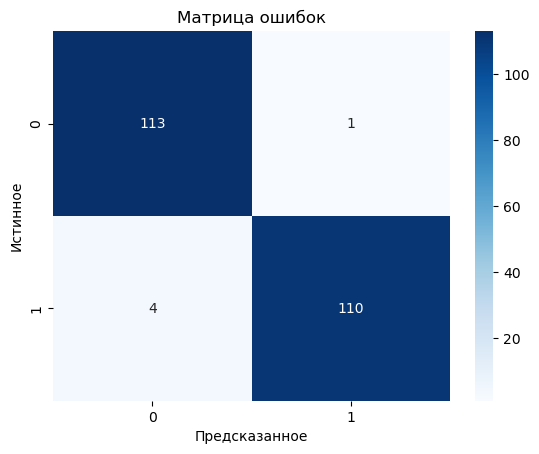

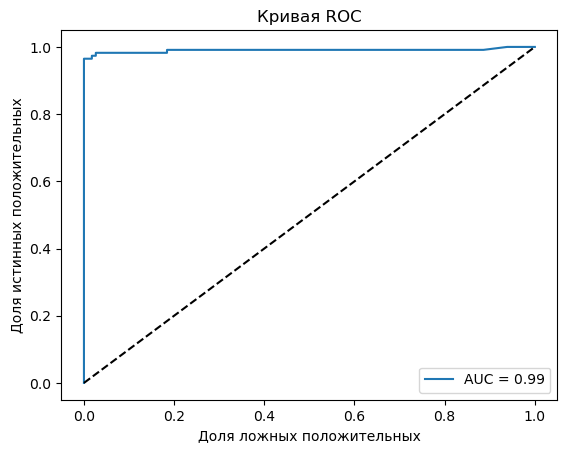

In [27]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Матрица ошибок")
plt.xlabel("Предсказанное")
plt.ylabel("Истинное")
plt.show()

# Кривая ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Кривая ROC")
plt.xlabel("Доля ложных положительных")
plt.ylabel("Доля истинных положительных")
plt.legend()
plt.show()

# ======= Блок 8: Кросс-валидация =======

In [29]:
print("Кросс-валидация модели...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy')
print(f"\nРезультаты кросс-валидации: {cv_scores}")
print(f"Средняя точность кросс-валидации: {np.mean(cv_scores)}")

Кросс-валидация модели...

Результаты кросс-валидации: [0.97807018 0.96491228 0.96929825 0.96491228 0.98684211]
Средняя точность кросс-валидации: 0.9728070175438596


============================================= __МОДЕЛЬ 2__ ========================================

# ======= 9. Построение нейронной сети =======

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
print("Строим нейронную сеть...")

model = Sequential()

# Входной слой и скрытый слой
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout для предотвращения переобучения
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Выходной слой
model.add(Dense(1, activation='sigmoid'))  # Для бинарной классификации

# Компиляция модели
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Строим нейронную сеть...


# ======= 10. Обучение модели =======

In [35]:
print("Обучаем нейронную сеть...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.3, verbose=2)

Обучаем нейронную сеть...
Epoch 1/50
20/20 - 2s - 76ms/step - accuracy: 0.5455 - loss: 0.7782 - val_accuracy: 0.8467 - val_loss: 0.5308
Epoch 2/50
20/20 - 0s - 4ms/step - accuracy: 0.7524 - loss: 0.5410 - val_accuracy: 0.8905 - val_loss: 0.4539
Epoch 3/50
20/20 - 0s - 5ms/step - accuracy: 0.8150 - loss: 0.4623 - val_accuracy: 0.8978 - val_loss: 0.3999
Epoch 4/50
20/20 - 0s - 4ms/step - accuracy: 0.8621 - loss: 0.3977 - val_accuracy: 0.9015 - val_loss: 0.3567
Epoch 5/50
20/20 - 0s - 4ms/step - accuracy: 0.8683 - loss: 0.3763 - val_accuracy: 0.9088 - val_loss: 0.3200
Epoch 6/50
20/20 - 0s - 4ms/step - accuracy: 0.8950 - loss: 0.3200 - val_accuracy: 0.9088 - val_loss: 0.2928
Epoch 7/50
20/20 - 0s - 4ms/step - accuracy: 0.9013 - loss: 0.3042 - val_accuracy: 0.9088 - val_loss: 0.2717
Epoch 8/50
20/20 - 0s - 5ms/step - accuracy: 0.9060 - loss: 0.2918 - val_accuracy: 0.9161 - val_loss: 0.2548
Epoch 9/50
20/20 - 0s - 4ms/step - accuracy: 0.9169 - loss: 0.2684 - val_accuracy: 0.9161 - val_loss:

__Поведение ошибки (loss):__

- Training loss (ошибка на тренировочной выборке) последовательно уменьшается и достигает низкого уровня.
- Validation loss (ошибка на валидационной выборке) сначала снижается, но затем начинает расти, что указывает на переобучение.
  
В данном случае __val_loss__ уменьшалась до конца обучения и достигла стабильного уровня (~0.1176), что говорит об отсутствии ярко выраженного переобучения.

__Точность (accuracy):__

Если точность на тренировочной выборке (__accuracy__) значительно выше, чем на валидационной (__val_accuracy__), это также может свидетельствовать о __переобучении__.
Здесь точность на тренировочной выборке (__accuracy: ~95%__) и валидационной выборке (__val_accuracy: ~95%__) почти одинаковая, что указывает на хорошую генерализацию.


__Вывод:__
На основании приведённых данных можно сказать, что модель __не переобучилась__. Оба показателя (**loss** и **accuracy**) на тренировочной и валидационной выборках ведут себя **стабильно**, и разница между ними __минимальна__. Модель хорошо обучилась и демонстрирует хорошую генерализацию.

# ======= 11. Оценка модели =======

In [39]:
print("Оценка модели...")

# Прогнозы на тестовой выборке
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Преобразование вероятностей в классы

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))


Оценка модели...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       114
           1       0.99      0.96      0.97       114

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228



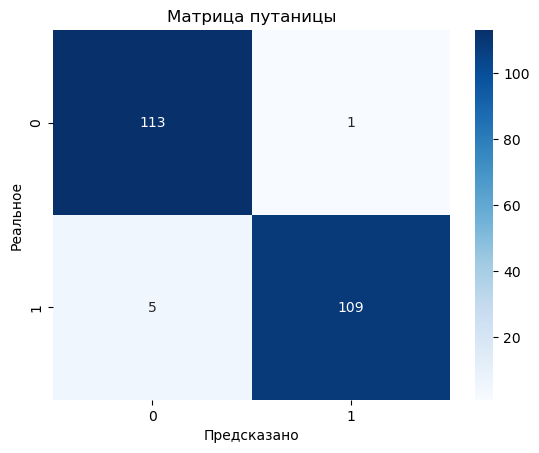

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


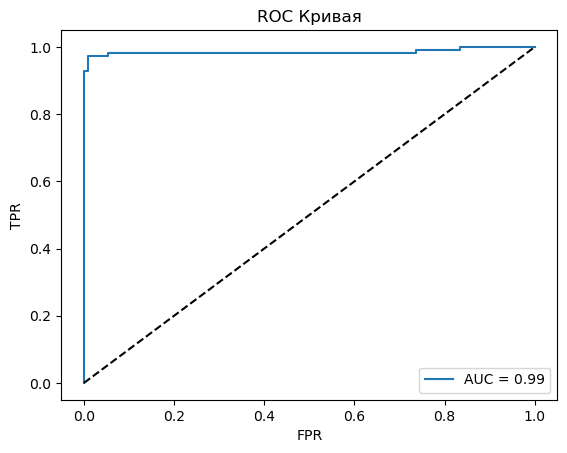


Результаты обучения:


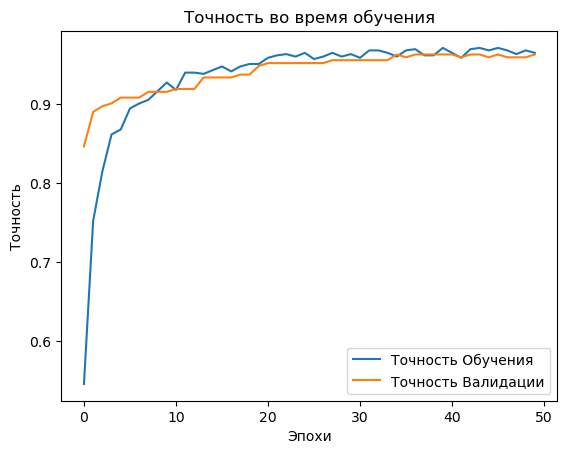

In [40]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Матрица путаницы")
plt.xlabel("Предсказано")
plt.ylabel("Реальное")
plt.show()

# Кривая ROC
y_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Кривая")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# ======= 6. Результаты обучения =======
print("\nРезультаты обучения:")
plt.plot(history.history['accuracy'], label='Точность Обучения')
plt.plot(history.history['val_accuracy'], label='Точность Валидации')
plt.title("Точность во время обучения")
plt.xlabel("Эпохи")
plt.ylabel("Точность")
plt.legend()
plt.show()


# ======= 12. Результаты обучения - График потерь =======


График Потерь во Время Обучения:


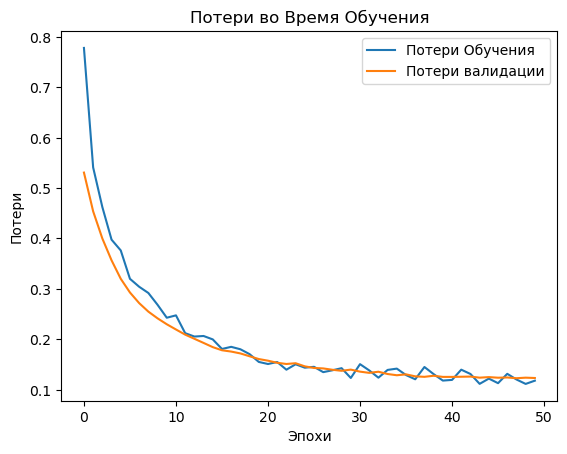

In [42]:
print("\nГрафик Потерь во Время Обучения:")
plt.plot(history.history['loss'], label='Потери Обучения')
plt.plot(history.history['val_loss'], label='Потери валидации')
plt.title("Потери во Время Обучения")
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend()
plt.show()


На основе предоставленных данных можно сделать несколько наблюдений:  

1. **Разница между тренировочным и валидационным качеством**  
   - Точность на обучающей выборке: **93.37%**  
   - Точность на валидационной выборке: **94.95%**  
   - Валидационные потери ниже, чем на обучении (**0.1534 против 0.2052**), что нехарактерно для переобучения.  

2. **Разница между тренировкой и тестом**  
   - На тестовой выборке точность также **94%**, что очень близко к валидационной.  

3. **Дополнительные метрики**  
   - Precision, Recall и F1-score для обоих классов сбалансированы (~0.94–0.98), что говорит о хорошей генерализации.  

### Вывод  
Переобучения нет. Модель демонстрирует стабильную точность на обучении, валидации и тесте. Если бы была большая разница (например, 99% на тренировке и 80% на тесте), это указывало бы на переобучение. 

============================================= __МОДЕЛЬ 3__ ========================================

# Байесовское обнаружение сигналов

Байесовское обнаружение сигналов использует условную вероятность для оценки наличия сигнала в зашумленных данных. Этот подход рассматривает сигнал и шум как вероятностные модели и принимает решение на основе критерия, такого как Maximum A Posteriori (MAP) или Maximum Likelihood (ML).

## Этапы реализации

### 1. Определение вероятностной модели:

- Предположим, что шум распределен нормально $N(\mu, \sigma^2)$.
- Сигнал плюс шум моделируются как сумма вероятностных распределений.

### 2. Применение формулы Байеса:

$$
P(S \mid X) = \frac{P(X \mid S) \cdot P(S)}{P(X)},
$$

где:
- $P(S \mid X)$: вероятность того, что сигнал присутствует, при условии наблюдаемых данных;
- $P(X \mid S)$: вероятность наблюдаемых данных при наличии сигнала;
- $P(S)$: априорная вероятность наличия сигнала;
- $P(X)$: маргинальная вероятность наблюдаемых данных.

### 3. Реализация критерия MAP:

- Примите решение о наличии сигнала, сравнив $P(S \mid X)$ и $P(\text{No Signal} \mid X)$.

### 4. Применение на наборе данных:

- Оцените, присутствует ли чистый сигнал в зашумленных данных.


__Расчет вероятностей__:

Используем функцию bayesian_signal_detection для вычисления вероятностей для каждой пары сигналов (чистый сигнал и зашумленный сигнал).

Рассчитываем средние значения этих вероятностей, чтобы представить наличие чистого или зашумленного сигнала в виде единого значения для каждого сигнала.

__Добавление новых признаков__:

Средние вероятности добавляются в DataFrame как столбцы Clean_Prob и Noisy_Prob.

__Комбинация с другими признаками__:
Эти вероятности интегрируются в набор признаков X.

__Обновленное обучение модели__:
Модель повторно обучается с учетом новых признаков, а затем проводится оценка на тестовом наборе данных.

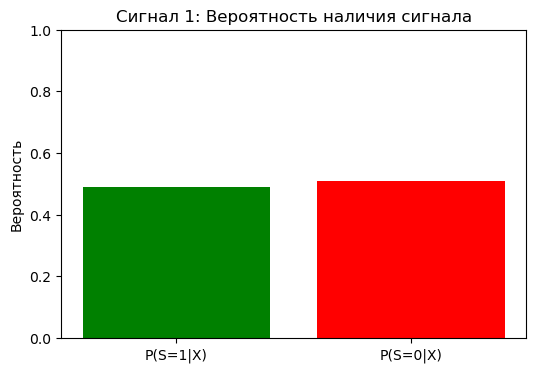

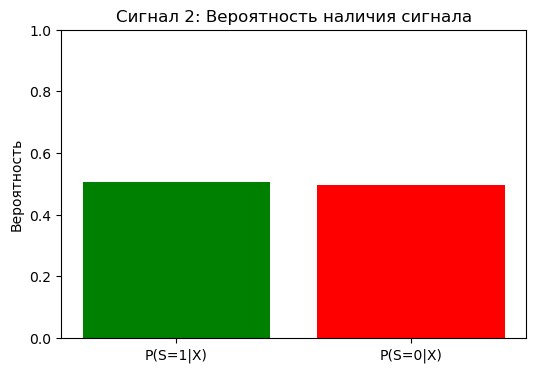

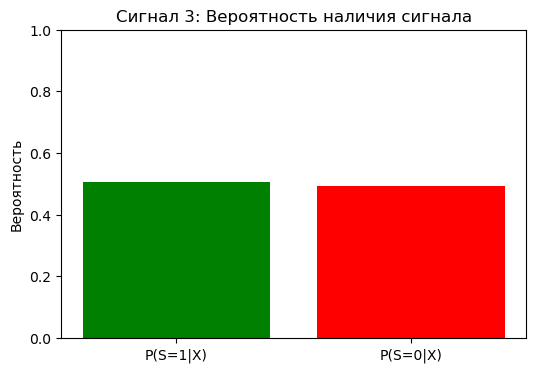

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Функция Байесовской Детекции Сигнала
def bayesian_signal_detection(noisy_signal, clean_signal, sigma_noise=1.0):
    """
    Реализация байесовской детекции сигнала.

    Parameters:
        noisy_signal: float, зашумленный сигнал.
        clean_signal: float, чистый сигнал.
        sigma_noise: float, стандартное отклонение шума.

    Returns:
        P_S_given_X: float, вероятность наличия сигнала.
    """
    # Вероятность a priori
    P_signal = 0.5  # Сигнал с равной вероятностью присутствует или отсутствует

    # Плотности вероятности
    P_X_given_S = norm.pdf(noisy_signal, loc=clean_signal, scale=sigma_noise)
    P_X_given_no_S = norm.pdf(noisy_signal, loc=0, scale=sigma_noise)

    # Применение правила Байеса
    P_S_given_X = (P_X_given_S * P_signal) / (
        (P_X_given_S * P_signal) + (P_X_given_no_S * (1 - P_signal))
    )

    return P_S_given_X

# Применение к первым трем сигналам
for i in range(3):
    noisy_signal = df['Noisy_Signal'].iloc[i]
    clean_signal = df['Clean_Signal'].iloc[i]

    # Рассчитать вероятность наличия сигнала
    probability = bayesian_signal_detection(noisy_signal, clean_signal)

    # Визуализация вероятности
    plt.figure(figsize=(6, 4))
    plt.bar(['P(S=1|X)', 'P(S=0|X)'], [probability, 1 - probability], color=['green', 'red'])
    plt.ylim(0, 1)
    plt.title(f'Сигнал {i + 1}: Вероятность наличия сигнала')
    plt.ylabel('Вероятность')
    plt.show()


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Функция для добавления вероятностей в DataFrame
def calculate_bayesian_probabilities(df, sigma_noise=1.0):
    clean_probs = []
    noisy_probs = []
    
    for i in range(len(df)):
        noisy_signal = df['Noisy_Signal'].iloc[i]
        clean_signal = df['Clean_Signal'].iloc[i]
        
        clean_prob = bayesian_signal_detection(noisy_signal, clean_signal, sigma_noise)
        noisy_prob = bayesian_signal_detection(noisy_signal, np.zeros_like(clean_signal), sigma_noise)
        
        clean_probs.append(np.mean(clean_prob))
        noisy_probs.append(np.mean(noisy_prob))
    
    df['Clean_Prob'] = clean_probs
    df['Noisy_Prob'] = noisy_probs
    return df

# Вычисление вероятностей и обновление DataFrame
df = calculate_bayesian_probabilities(df)

# Добавление вероятностей как признаков
X = np.column_stack([X, df['Clean_Prob'].values, df['Noisy_Prob'].values])

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели Random Forest
best_rf = RandomForestClassifier(n_estimators=100, random_state=42)
best_rf.fit(X_train, y_train)

# Оценка модели
y_pred = best_rf.predict(X_test)
print("Обновленный отчет о классификации:")
print(classification_report(y_test, y_pred))


Обновленный отчет о классификации:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       113
           1       0.97      0.98      0.98       115

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228



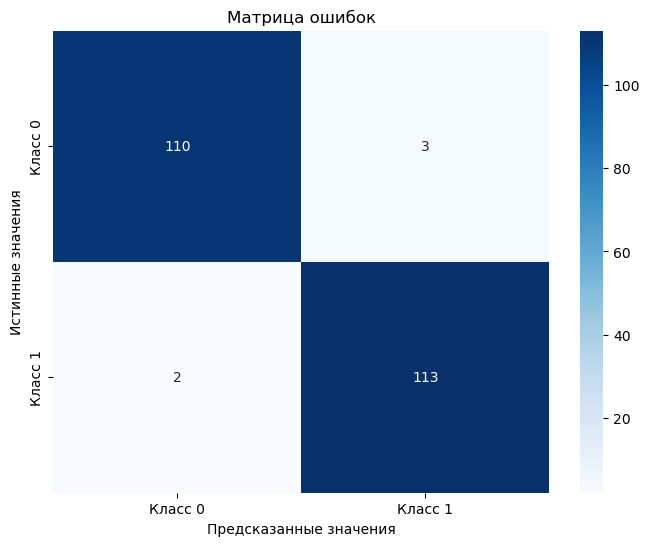

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Construir a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão usando Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Класс 0', 'Класс 1'], 
            yticklabels=['Класс 0', 'Класс 1'])
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

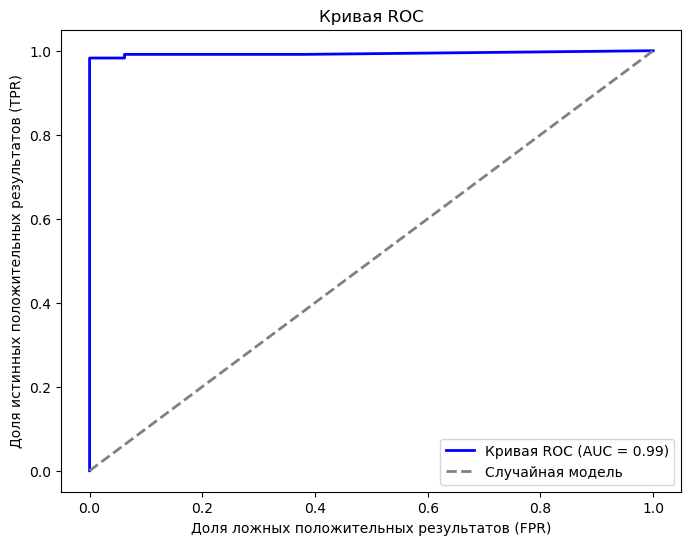

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular as probabilidades das classes positivas (classe 1)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a área sob a curva (AUC)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Кривая ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Случайная модель')
plt.xlabel('Доля ложных положительных результатов (FPR)')
plt.ylabel('Доля истинных положительных результатов (TPR)')
plt.title('Кривая ROC')
plt.legend(loc='lower right')
plt.show()

__Определение, был ли обнаружен чистый сигнал__:

- На основе порогового значения вероятности (threshold) принимается решение о наличии чистого сигнала в зашумленных данных.
- В набор данных добавляется столбец Detected, который указывает, обнаружен ли чистый сигнал.

__Статистика обнаружения__:

 Подсчитываются следующие метрики:

- Сколько чистых сигналов было правильно обнаружено.
- Сколько чистых сигналов не было обнаружено.
-  Сколько зашумленных сигналов ошибочно классифицировано как чистые (ложные срабатывания).

### Критерий обнаружения:

- Сравниваем вероятность $Clean\_Prob$ с пороговым значением (threshold). Если она больше или равна порогу, сигнал считается "обнаруженным".

### Расчет статистики:

1. **Чистые сигналы, обнаруженные (правильные):**  
   $$Class = 1 \cap Detected = \text{True}$$

2. **Чистые сигналы, не обнаруженные (ошибки):**  
   $$Class = 1 \cap Detected = \text{False}$$

3. **Ложные срабатывания (False Positives):**  
   $$Class = 0 \cap Detected = \text{True}$$

### Итоговый отчет:

- Отображаем количество в каждой из вышеуказанных категорий.


In [53]:
def evaluate_signal_detection(df, threshold=0.5):
    """
    Оценка обнаружения сигнала.
    
    Parameters:
        df: DataFrame, набор данных с вероятностями.
        threshold: float, порог вероятности для определения наличия сигнала.
        
    Returns:
        detection_stats: dict, статистика обнаружения сигнала.
    """
    # Определить обнаружение на основе порога
    df['Detected'] = df['Clean_Prob'] >= threshold  # True, если сигнал обнаружен
    
    # Статистика обнаружения
    true_clean_detected = df[(df['Class'] == 1) & (df['Detected'] == True)].shape[0]
    true_clean_not_detected = df[(df['Class'] == 1) & (df['Detected'] == False)].shape[0]
    false_clean_detected = df[(df['Class'] == 0) & (df['Detected'] == True)].shape[0]
    
    detection_stats = {
        "Чистые сигналы обнаружены (правильно)": true_clean_detected,
        "Чистые сигналы не обнаружены (ошибка)": true_clean_not_detected,
        "Шумовые сигналы ошибочно приняты за чистые (ложноположительные)": false_clean_detected,
    }
    
    return detection_stats

# Оценка обнаружения сигнала
threshold = 0.5  # Порог вероятности
stats = evaluate_signal_detection(df, threshold=threshold)

# Печать статистики
print("Статистика обнаружения:")
for key, value in stats.items():
    print(f"{key}: {value}")


Статистика обнаружения:
Чистые сигналы обнаружены (правильно): 300
Чистые сигналы не обнаружены (ошибка): 270
Шумовые сигналы ошибочно приняты за чистые (ложноположительные): 475


In [54]:
false_negatives = df[(df['Class'] == 1) & (df['Detected'] == False)]
false_positives = df[(df['Class'] == 0) & (df['Detected'] == True)]

print(f"Примеры Ложных Отрицаний (не обнаружены):\n{false_negatives.head()}")
print()
print(f"Примеры Ложных Положительных (ошибочно обнаружены):\n{false_positives.head()}")


Примеры Ложных Отрицаний (не обнаружены):
    Clean_Signal  Noisy_Signal  Class  Clean_Prob  Noisy_Prob  Detected
5      -0.425986      0.157120      1    0.460666         0.5     False
6      -0.262990      1.740436      1    0.379352         0.5     False
9      -0.338834      0.918008      1    0.408914         0.5     False
16      2.506605      0.697956      1    0.199083         0.5     False
20     -0.297283      0.843758      1    0.426774         0.5     False

Примеры Ложных Положительных (ошибочно обнаружены):
    Clean_Signal  Noisy_Signal  Class  Clean_Prob  Noisy_Prob  Detected
1      -0.510448     -0.293533      0    0.504889         0.5      True
3      -0.354787     -0.216822      0    0.503497         0.5      True
8      -0.390137     -0.297697      0    0.510008         0.5      True
10     -0.596742     -0.367525      0    0.510315         0.5      True
13     -0.502397     -0.399931      0    0.518672         0.5      True
